In [34]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import json
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from datetime import datetime
from sklearn import linear_model
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
from sklearn.neural_network import MLPRegressor
from enum import Enum
import warnings
warnings.filterwarnings("ignore")

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/covid19-global-forecasting-week-4/train.csv
/kaggle/input/covid19-global-forecasting-week-4/submission.csv
/kaggle/input/covid19-global-forecasting-week-4/test.csv
/kaggle/input/novel-corona-virus-2019-dataset/time_series_covid_19_confirmed.csv
/kaggle/input/novel-corona-virus-2019-dataset/time_series_covid_19_deaths_US.csv
/kaggle/input/novel-corona-virus-2019-dataset/time_series_covid_19_recovered.csv
/kaggle/input/novel-corona-virus-2019-dataset/COVID19_open_line_list.csv
/kaggle/input/novel-corona-virus-2019-dataset/time_series_covid_19_deaths.csv
/kaggle/input/novel-corona-virus-2019-dataset/covid_19_data.csv
/kaggle/input/novel-corona-virus-2019-dataset/time_series_covid_19_confirmed_US.csv
/kaggle/input/novel-corona-virus-2019-dataset/COVID19_line_list_data.csv


In [36]:
### shows growth over time for a specified country
def plot_given_data(region_of_interest):
    if (region_of_interest[1] == 'province'):
        region_data = train[train['Province_State'] == region_of_interest[0]]
    else:
        region_data = train[train['Country_Region'] == region_of_interest[0]]  

    dates = region_data['Date'].unique()
    cases_by_date = {}
    fatalities_by_date = {}
    for d in dates:
        day = region_data[region_data['Date'] == d]
        cases_by_date[d] = sum(day['ConfirmedCases'])
        fatalities_by_date[d] = sum(day['Fatalities'])

    plt.figure(figsize=(15, 5))
    plt.grid(True, axis='y')
    plt.xticks(rotation=-90)
    plt.title(region_of_interest[0] + ': by day')
    plt.bar(list(dates), cases_by_date.values(), log=True, label="Cases by day")
    plt.bar(list(dates), fatalities_by_date.values(), log=True, label="Fatalities by day")
    plt.legend()

In [37]:
class Regression(Enum):
    NONE = 0
    LOGISTIC_REGRESSION = 1
    LOGISTIC_EQUATION = 2
    LEAST_SQUARES_LOGISTIC = 3
    MLP_REGRESSOR = 4
p_max_rsquared = [0, Regression.NONE]
c_max_rsquared = [0, Regression.NONE]

In [38]:
def plot_confirmed_by_time(region_of_interest):
    global province, country, c_in_country, c_in_province
    confirmed_by_time = pd.read_csv('../input/novel-corona-virus-2019-dataset/time_series_covid_19_confirmed.csv')
    confirmed_by_time = confirmed_by_time.fillna('-')
    c_useful_cols = [col for col in confirmed_by_time.columns if col.split('/')[0].isdigit()]
    if (region_of_interest[1] == 'country'): 
        country = region_of_interest[0]
        province = 'No Province'
    else:
        country = map_province_to_country[region_of_interest[0]]
        province = region_of_interest[0]
    c_in_country = confirmed_by_time[confirmed_by_time['Country/Region'] == country][c_useful_cols]
    c_in_province = confirmed_by_time[confirmed_by_time['Province/State'] == province][c_useful_cols]

    fig, axs = plt.subplots(2, 1, figsize=(15, 10))
    plt.subplots_adjust(hspace=0.5)

    if (len(c_in_province) > 0): # if data for province is found
        # calculating new cases in province per day
        c_new_in_province = {}
        for i in range(1, len(c_useful_cols)):
            diff = c_in_province.values[0][i] - c_in_province.values[0][i-1]
            c_new_in_province[c_useful_cols[i]] = diff

        # plotting cases in province
        axs[0].grid(True, axis='y')
        axs[0].set_xticklabels(list(c_useful_cols), rotation=-90)
        axs[0].set_title(province)
        axs[0].bar(list(c_useful_cols), c_in_province.values[0], log=True, label="Cumulative cases")
        axs[0].bar(c_new_in_province.keys(), c_new_in_province.values(), log=True, label="New cases")
        axs[0].legend()
    else: # if data for province is not found
        axs[0].set_title(province)
        axs[0].text(0.5, 0.5, 'No Data Available for ' + province, bbox={'facecolor': 'red', 'alpha': 0.3, 'pad': 10}, horizontalalignment='center', verticalalignment='center', transform=axs[0].transAxes)

    # calculating new cases in country per day
    c_new_in_country = {}
    for i in range(1, len(c_useful_cols)):
        diff = c_in_country.values[0][i] - c_in_country.values[0][i-1]
        c_new_in_country[c_useful_cols[i]] = diff

    # plotting cases in country
    axs[1].grid(True, axis='y')
    axs[1].set_xticklabels(list(c_useful_cols), rotation=-90)
    axs[1].set_title(country)
    axs[1].bar(list(c_useful_cols), c_in_country.values[0], log=True, label="Cumulative cases")
    axs[1].bar(c_new_in_country.keys(), c_new_in_country.values(), log=True, label="New cases")
    axs[1].legend()

In [39]:
### logistic regression using time series data
def logistic_regression(indexed_dates):
    global c_max_rsquared, p_max_rsquared
    fig, axs = plt.subplots(2, 1, figsize=(15, 10))
    for ax in axs:
        for spine in ax.spines.values():
            spine.set_edgecolor('green')
            spine.set_linewidth(2)

    if (len(c_in_province) > 0):
        p_regr = linear_model.LogisticRegression(C=1e5, max_iter=1000)
        p_len_diff = len(indexed_dates) - len(c_in_province.values[0])
        if (p_len_diff > 0):
            indexed_dates = indexed_dates[:-len_diff]
        elif (p_len_diff < 0):
            c_in_province.values[0] = c_in_province.values[0][:-p_len_diff]
        province_reg = p_regr.fit(indexed_dates, c_in_province.values[0])

        p_predictions = province_reg.predict(indexed_dates)
        p_abs_error = p_predictions - c_in_province.values[0].astype(float)
        p_SE = np.square(p_abs_error) # squared errors
        p_MSE = np.mean(p_SE) # mean squared errors
        p_RMSE = np.sqrt(p_MSE) # Root Mean Squared Error, RMSE
        p_Rsquared = 1.0 - (np.var(p_abs_error) / np.var(list(c_in_province.values[0].astype(float))))
        if (p_Rsquared > p_max_rsquared[0]):
            p_max_rsquared[0] = p_Rsquared
            p_max_rsquared[1] = Regression.LOGISTIC_REGRESSION

        axs[0].grid(True, axis='y')
        axs[0].set_title(province + ': Cases by day')
        axs[0].scatter(indexed_dates, c_in_province.values[0])
        axs[0].plot(p_predictions, color='orange', label='R-squared=' + str(p_Rsquared))
        axs[0].plot(prediction_input, province_reg.predict(prediction_input), color='red')
        axs[0].legend()
    else:
        axs[0].set_title(province)
        axs[0].text(0.5, 0.5, 'No Data Available for ' + province, bbox={'facecolor': 'red', 'alpha': 0.3, 'pad': 10}, horizontalalignment='center', verticalalignment='center', transform=axs[0].transAxes)

    c_regr = linear_model.LogisticRegression(C=1e5, max_iter=1000)
    c_len_diff = len(indexed_dates) - len(c_in_country.values[0])
    if (c_len_diff > 0):
        indexed_dates = indexed_dates[:-len_diff]
    elif (c_len_diff < 0):
        c_in_country.values[0] = c_in_country.values[0][:-c_len_diff]    
    country_reg = c_regr.fit(indexed_dates, c_in_country.values[0])

    c_predictions = country_reg.predict(indexed_dates)
    c_abs_error = c_predictions - c_in_country.values[0].astype(float)
    c_SE = np.square(c_abs_error) # squared errors
    c_MSE = np.mean(c_SE) # mean squared errors
    c_RMSE = np.sqrt(c_MSE) # Root Mean Squared Error, RMSE
    c_Rsquared = 1.0 - (np.var(c_abs_error) / np.var(list(c_in_country.values[0].astype(float))))
    if (c_Rsquared > c_max_rsquared[0]):
            c_max_rsquared[0] = c_Rsquared
            c_max_rsquared[1] = Regression.LOGISTIC_REGRESSION

    axs[1].grid(True, axis='y')
    axs[1].set_title(country + ': Cases by day')
    axs[1].scatter(indexed_dates, c_in_country.values[0])
    axs[1].plot(c_predictions, color='orange', label='R-squared=' + str(c_Rsquared))
    axs[1].plot(prediction_input, country_reg.predict(prediction_input), color='red')
    axs[1].legend()

In [40]:
### fitting time series data to logistic equation
def func(x, a, b, c, d):
        return a / (b + np.exp(c*(x+d)))

def logistic_equation():
    global c_max_rsquared, p_max_rsquared
    fig, axs = plt.subplots(2, 1, figsize=(15, 10))
    for ax in axs:
        for spine in ax.spines.values():
            spine.set_edgecolor('#1233D8')
            spine.set_linewidth(2)

    if (len(c_in_province) > 0):
        # curve fit the test data, ignoring warning due to initial parameter estimates
        p_params, pcov = curve_fit(func, indexed_dates.flatten(), c_in_province.values[0].astype(float))
        p_predictions = func(indexed_dates.flatten(), *p_params) 

        p_abs_error = p_predictions - c_in_province.values[0].astype(float)
        p_SE = np.square(p_abs_error) # squared errors
        p_MSE = np.mean(p_SE) # mean squared errors
        p_RMSE = np.sqrt(p_MSE) # Root Mean Squared Error, RMSE
        p_Rsquared = 1.0 - (np.var(p_abs_error) / np.var(list(c_in_province.values[0].astype(float))))
        if (p_Rsquared > p_max_rsquared[0]):
            p_max_rsquared[0] = p_Rsquared
            p_max_rsquared[1] = Regression.LOGISTIC_EQUATION

        axs[0].grid(True, axis='y')
        axs[0].set_title(province + ': Cases by day')
        axs[0].scatter(indexed_dates, c_in_province.values[0])
        axs[0].plot(p_predictions, color='orange', label='R-squared=' + str(p_Rsquared))
        axs[0].plot(prediction_input, func(prediction_input, *p_params), color='red')
        axs[0].legend()
    else:
        axs[0].set_title(province)
        axs[0].text(0.5, 0.5, 'No Data Available for ' + province, bbox={'facecolor': 'red', 'alpha': 0.3, 'pad': 10}, horizontalalignment='center', verticalalignment='center', transform=axs[0].transAxes)

    c_params, pcov = curve_fit(func, indexed_dates.flatten(), c_in_country.values[0].astype(float))
    c_predictions = func(indexed_dates.flatten(), *c_params) 

    c_abs_error = c_predictions - c_in_country.values[0].astype(float)
    c_SE = np.square(c_abs_error) # squared errors
    c_MSE = np.mean(c_SE) # mean squared errors
    c_RMSE = np.sqrt(c_MSE) # Root Mean Squared Error, RMSE
    c_Rsquared = 1.0 - (np.var(c_abs_error) / np.var(list(c_in_country.values[0].astype(float))))
    if (c_Rsquared > c_max_rsquared[0]):
            c_max_rsquared[0] = c_Rsquared
            c_max_rsquared[1] = Regression.LOGISTIC_EQUATION

    axs[1].grid(True, axis='y')
    axs[1].set_title(country + ': Cases by day')
    axs[1].scatter(indexed_dates, c_in_country.values[0])
    axs[1].plot(c_predictions, color='orange', label='R-squared=' + str(c_Rsquared))
    axs[1].plot(prediction_input, func(prediction_input, *c_params), color='red')
    axs[1].legend()

In [41]:
### using least squares optimization to fit data to logistic equation
def fun(x, t, y):
    return -y + (x[0] / (x[1] + np.exp(x[2] * t + x[3])))

def predict(t, a, b, c, d):
    return (a / (b + np.exp(c * t + d)))

def least_squares_logistic():
    global c_max_rsquared, p_max_rsquared
    fig, axs = plt.subplots(2, 1, figsize=(15, 10))
    for ax in axs:
        for spine in ax.spines.values():
            spine.set_edgecolor('#AD7616')
            spine.set_linewidth(2)

    if (len(c_in_province) > 0):
        t_train = indexed_dates.flatten()
        y_train = c_in_province.values[0].astype(float)

        x0 = np.array([1.0, 1.0, 1.0, 1.0])
        res_lsq = least_squares(fun, x0, args=(t_train, y_train))
        res_soft_l1 = least_squares(fun, x0, loss='soft_l1', f_scale=0.1, args=(t_train, y_train))
        res_log = least_squares(fun, x0, loss='huber', f_scale=0.1,args=(t_train, y_train))

        print('lsq:\t', *res_lsq.x)
        print('soft_l1:', *res_soft_l1.x)
        print('huber:\t', *res_log.x)

        t_test = prediction_input.flatten()
        y_lsq = predict(t_test, *res_lsq.x)
        y_soft_l1 = predict(t_test, *res_soft_l1.x)
        y_log = predict(t_test, *res_log.x)
        y_for_training_data = predict(t_train, *res_lsq.x)

        abs_error = y_for_training_data - c_in_province.values[0].astype(float)
        p_Rsquared = 1.0 - (np.var(abs_error) / np.var(list(c_in_province.values[0].astype(float))))
        if (p_Rsquared > p_max_rsquared[0]):
            p_max_rsquared[0] = p_Rsquared
            p_max_rsquared[1] = Regression.LEAST_SQUARES_LOGISTIC

        axs[0].grid(True, axis='y')
        axs[0].set_title(province + ": Cases by day")
        axs[0].scatter(t_train, y_train)
        axs[0].plot(t_test, y_lsq, label='linear loss')
        axs[0].plot(t_test, y_soft_l1, label='soft_l1 loss')
        axs[0].plot(t_test, y_log, label='huber loss')
        axs[0].plot(t_train, y_for_training_data, label='R-squared=' + str(p_Rsquared), color='orange')
        axs[0].legend()
    else:
        axs[0].set_title(province)
        axs[0].text(0.5, 0.5, 'No Data Available for ' + province, bbox={'facecolor': 'red', 'alpha': 0.3, 'pad': 10}, horizontalalignment='center', verticalalignment='center', transform=axs[0].transAxes)

    t_train = indexed_dates.flatten()
    y_train = c_in_country.values[0].astype(float)

    x0 = np.array([1.0, 1.0, 1.0, 1.0])
    res_lsq = least_squares(fun, x0, args=(t_train, y_train))

    t_test = prediction_input.flatten()
    y_lsq = predict(t_test, *res_lsq.x)
    y_for_training_data = predict(t_train, *res_lsq.x)

    abs_error = y_for_training_data - c_in_country.values[0].astype(float)
    c_Rsquared = 1.0 - (np.var(abs_error) / np.var(list(c_in_country.values[0].astype(float))))
    if (c_Rsquared > c_max_rsquared[0]):
            c_max_rsquared[0] = c_Rsquared
            c_max_rsquared[1] = Regression.LEAST_SQUARES_LOGISTIC

    axs[1].grid(True, axis='y')
    axs[1].set_title(country + ": Cases by day")
    axs[1].scatter(t_train, y_train)
    axs[1].plot(t_test, y_lsq, color='red')
    axs[1].plot(t_train, y_for_training_data, label='R-squared=' + str(c_Rsquared), color='orange')
    axs[1].legend()

In [42]:
### using multi layer perceptron regression (MLP Regressor)
def mlp_regression():
    global c_max_rsquared, p_max_rsquared
    fig, axs = plt.subplots(2, 1, figsize=(15, 10))
    for ax in axs:
        for spine in ax.spines.values():
            spine.set_edgecolor('#D83512')
            spine.set_linewidth(2)
            
    if (len(c_in_province) > 0):
        x_train = indexed_dates#.flatten()
        y_train = c_in_province.values[0].astype(float)

        model = MLPRegressor([6], activation='logistic', validation_fraction=0, solver='lbfgs', max_iter=10000).fit(x_train, y_train)
        coefs = model.coefs_
        predictions = model.predict(prediction_input)
        abs_error = model.predict(x_train) - c_in_province.values[0].astype(float)
        p_Rsquared = 1.0 - (np.var(abs_error) / np.var(list(c_in_province.values[0].astype(float))))
        hiddens = coefs[0].T
        final_mlp = coefs[1].flatten()
        if (p_Rsquared > p_max_rsquared[0] or p_Rsquared - p_max_rsquared[0] > -0.01):
            p_max_rsquared[0] = p_Rsquared
            p_max_rsquared[1] = Regression.MLP_REGRESSOR

        axs[0].grid(True, axis='y')
        axs[0].set_title(province + ": Cases by day")
        axs[0].scatter(x_train, y_train)
        axs[0].plot(x_train, model.predict(x_train), color='orange', label='R-squared=' + str(p_Rsquared))
        axs[0].plot(prediction_input, predictions, color='red')
        axs[0].legend()
    else:
        axs[0].set_title(province)
        axs[0].text(0.5, 0.5, 'No Data Available for ' + province, bbox={'facecolor': 'red', 'alpha': 0.3, 'pad': 10}, horizontalalignment='center', verticalalignment='center', transform=axs[0].transAxes)

    x_train = indexed_dates#.flatten()
    y_train = c_in_country.values[0].astype(float)

    model = MLPRegressor([6], activation='logistic', validation_fraction=0, solver='lbfgs', max_iter=10000).fit(x_train, y_train)
    coefs = model.coefs_
    predictions = model.predict(prediction_input)
    abs_error = model.predict(x_train) - c_in_country.values[0].astype(float)
    c_Rsquared = 1.0 - (np.var(abs_error) / np.var(list(c_in_country.values[0].astype(float))))
    hiddens = coefs[0].T
    final_mlp = coefs[1].flatten()
    if (c_Rsquared > c_max_rsquared[0] or c_Rsquared - c_max_rsquared[0] > -0.01):
        c_max_rsquared[0] = c_Rsquared
        c_max_rsquared[1] = Regression.MLP_REGRESSOR

    axs[1].grid(True, axis='y')
    axs[1].set_title(country + ": Cases by day")
    axs[1].scatter(x_train, y_train)
    axs[1].plot(x_train, model.predict(x_train), color='orange', label='R-squared=' + str(c_Rsquared))
    axs[1].plot(prediction_input, predictions, color='red')
    axs[1].legend()

In [35]:
train = pd.read_csv('../input/covid19-global-forecasting-week-4/train.csv')
train = train.fillna('-')

with_province = train[train['Province_State'] != '-']
provinces = with_province['Province_State'].unique()
map_province_to_country = {}
for p in provinces:
    map_province_to_country[p] = list(with_province[with_province['Province_State'] == p]['Country_Region'])[0]
# print(json.dumps(map_province_to_country, indent=0))

In [43]:
region_of_interest = ['New York', 'province'] # format is [name, type] where type is either 'province' or 'country'

open_line_list = pd.read_csv('../input/novel-corona-virus-2019-dataset/COVID19_open_line_list.csv')
useful_cols = [col for col in open_line_list.columns if not 'Unnamed' in col]
useful = open_line_list[useful_cols]
useful = useful.fillna('-')
useful = useful[useful.ID != '-']

if (region_of_interest[1] == 'province'):
    roi_data = useful[useful['province'] == region_of_interest[0]]
    country = map_province_to_country[region_of_interest[0]]
    if (country == "US"): 
        country = "United States"
    country_data = useful[useful['country'] == country]
else:
    roi_data = useful[useful['country'] == region_of_interest[0]] 
    country_data = []
        
roi_confirmations_by_date = {}
dates = roi_data['date_confirmation'].values
for d in dates:
    if (d == '-'): continue
    try:
        roi_confirmations_by_date[d] = roi_confirmations_by_date[d] + 1
    except:
        roi_confirmations_by_date[d] = 1

if (len(country_data) > 0):
    country_confirmations_by_date = {}
    dates = country_data['date_confirmation'].values
    for d in dates:
        if (d == '-'): continue
        try:
            country_confirmations_by_date[d] = country_confirmations_by_date[d] + 1
        except:
            country_confirmations_by_date[d] = 1



ValueError: could not broadcast input array from shape (79) into shape (96)

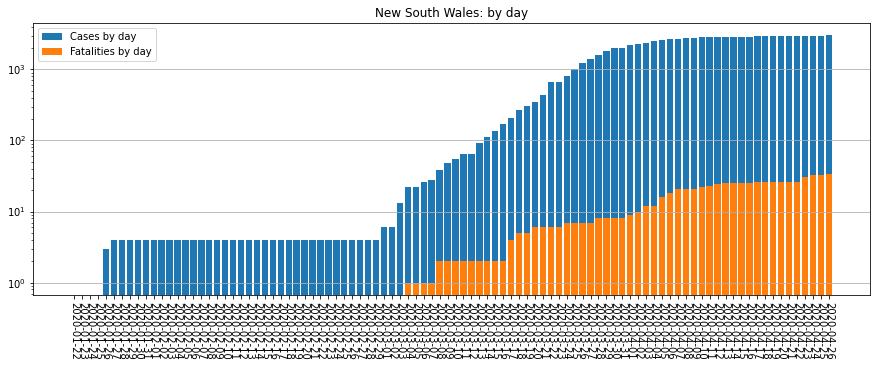

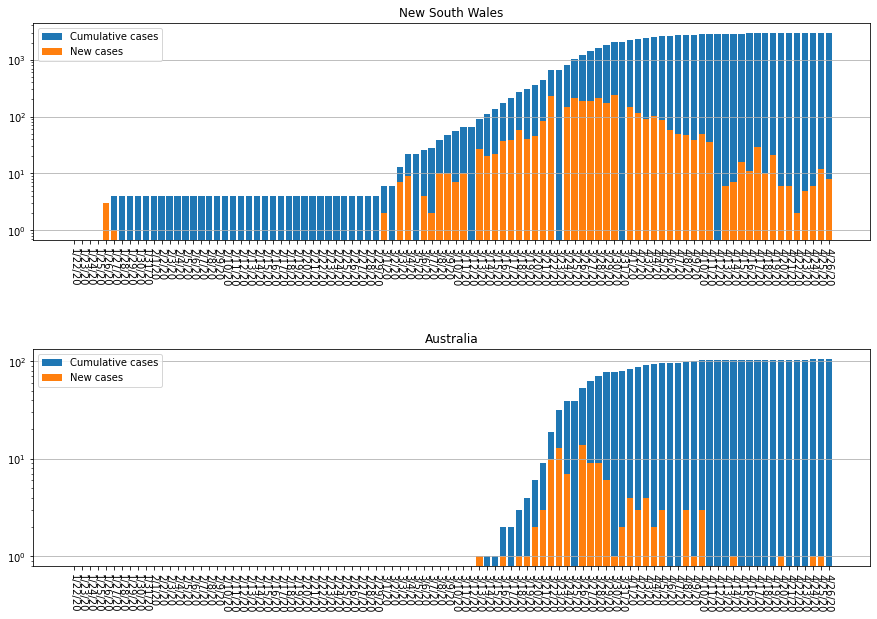

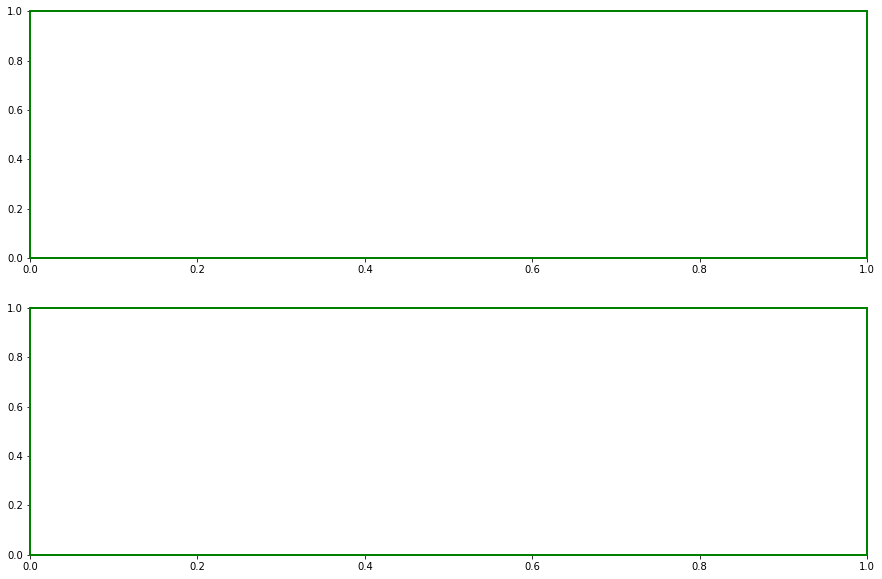

In [44]:
indexed_dates = np.arange(1, len(dates)+1)
indexed_dates.shape = (len(dates), 1)
prediction_input = np.arange(len(dates)+1, len(dates)+11)
prediction_input.shape = (10, 1)

region_of_interest = ['New South Wales', 'province'] # format is [name, type] where type is either 'province' or 'country'
province = ''
country = ''
plot_given_data(region_of_interest)
plot_confirmed_by_time(region_of_interest)
    
logistic_regression(indexed_dates) # green graph
logistic_equation() # blue graph
least_squares_logistic() # amber graph
mlp_regression() # red graph

print(p_max_rsquared)
print(c_max_rsquared)

In [ ]:
test = pd.read_csv('../input/covid19-global-forecasting-week-4/test.csv').fillna('-')
print(len(test))
test_dates = test['Date'].unique()
d0 = datetime.strptime(dates[0], "%Y-%m-%d")
date_map = {}
for d in test_dates:
    d1 = datetime.strptime(d, "%Y-%m-%d")
    date_map[d] = (abs((d1 - d0).days) + 1)
last_given_indexed_date = indexed_dates[-1]

if (p_max_rsquared[1] == Regression.LOGISTIC_REGRESSION):
    province_regression = logistic_regression
elif (p_max_rsquared[1] == Regression.LOGISTIC_EQUATION):
    province_regression = logistic_equation
elif (p_max_rsquared[1] == Regression.LEAST_SQUARES_LOGISTIC):
    province_regression = least_squares_logistic
elif (p_max_rsquared[1] == Regression.MLP_REGRESSOR):
    province_regression = mlp_regression
    
if (c_max_rsquared[1] == Regression.LOGISTIC_REGRESSION):
    country_regression = logistic_regression
elif (c_max_rsquared[1] == Regression.LOGISTIC_EQUATION):
    country_regression = logistic_equation
elif (c_max_rsquared[1] == Regression.LEAST_SQUARES_LOGISTIC):
    country_regression = least_squares_logistic
elif (c_max_rsquared[1] == Regression.MLP_REGRESSOR):
    country_regression = mlp_regression
      
predictions = {}
tests = test['ForecastId'].unique()
count = 0
for i in range(100):
    if (test['Province_State'][i] == '-'):
        indexed_date = date_map[test['Date'][i]]
        if (indexed_date <= last_given_indexed_date):
            predictions[i] = 
        print(indexed_date)
        count = count + 1
print(count)

# provinces = test['Province_State'].unique()
# countries = test['Country_Region'].unique()
# print(len(provinces), len(countries))
# count = 0
# for p in provinces:
#     try:
#         a = map_province_to_country[p]
#     except:
#         count = count+1
# print(count)

In [ ]:
# ### logistic regression
# cases_logistic = linear_model.LogisticRegression(C=1e5, max_iter=500)
# fatalities_logistic = linear_model.LogisticRegression(C=1e5, max_iter=500)

# c_reg2 = cases_logistic.fit(indexed_dates, list(cases_by_date.values()))
# f_reg2 = fatalities_logistic.fit(indexed_dates, list(fatalities_by_date.values()))

# fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# axs[0].grid(True, axis='y')
# axs[0].set_title('Cases by day')
# axs[0].scatter(indexed_dates, list(cases_by_date.values()))
# axs[0].plot(c_reg2.predict(indexed_dates), color='orange')
# axs[0].plot(prediction_input, c_reg2.predict(prediction_input), color='red')

# axs[1].grid(True, axis='y')
# axs[1].set_title('Fatalities by day')
# axs[1].scatter(indexed_dates, list(fatalities_by_date.values()))
# axs[1].plot(f_reg2.predict(indexed_dates), color='orange')
# axs[1].plot(prediction_input, f_reg2.predict(prediction_input), color='red')